In [1]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv
import pandas as pd
import polars as pl
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

from numba import njit
from datetime import datetime

from support.pd_support import *

In [2]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "cam_june_22_2023"
_calib_folder_name = "calibration_00"

_folder_name = "sk40_30_4_static_mocap_3"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "webcam_rotmat_1.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)


In [3]:
_ar_lframe_org

array([[-0.01867946],
       [ 0.01802945],
       [ 0.65143383]])

In [4]:
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
markerLength = 0.04
markerSeparation = 0.01

board = aruco.GridBoard_create(
        markersX=1,
        markersY=1,
        markerLength=markerLength,
        markerSeparation=markerSeparation,
        dictionary=ARUCO_DICT)

In [5]:
# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [6]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [0, 49, 80]

data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

for _frame in tqdm(_video_data):

    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
        image = gray,
        board = board,
        detectedCorners = corners,
        detectedIds = ids,
        rejectedCorners = rejectedImgPoints,
        cameraMatrix = _webcam_cam_mat,
        distCoeffs = _webcam_dist)

    rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(corners, 0.04, _webcam_cam_mat, _webcam_dist)

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(translation_vectors)
        data["rvec"].append(rotation_vectors)

    counter+=1


_video_file.close()

142it [00:02, 68.09it/s]


In [7]:
coordinate = {"0":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "49":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "80":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame

for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:

        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        for j in range(len(data["marker_ids"][i])):
            if data["marker_ids"][i][j] in default_ids:
                coordinate[str(data["marker_ids"][i][j][0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(data["marker_ids"][i][j][0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["rz"].append(data["rvec"][i][j][0][2])
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
        doesnt_exist = []
    else:
        for k in default_ids:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

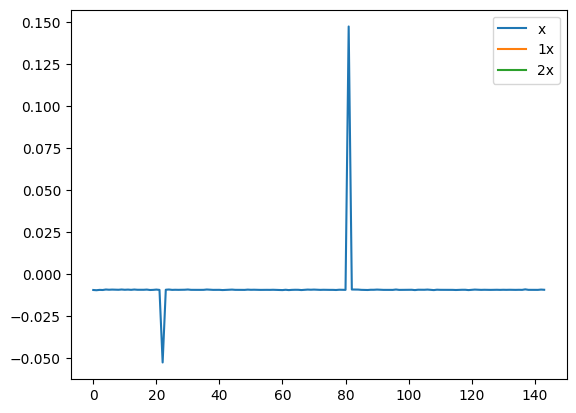

In [8]:
plt.plot(coordinate["0"]["x"], label="x")
plt.plot(coordinate["49"]["x"], label="1x")
plt.plot(coordinate["80"]["x"], label="2x")
plt.legend()

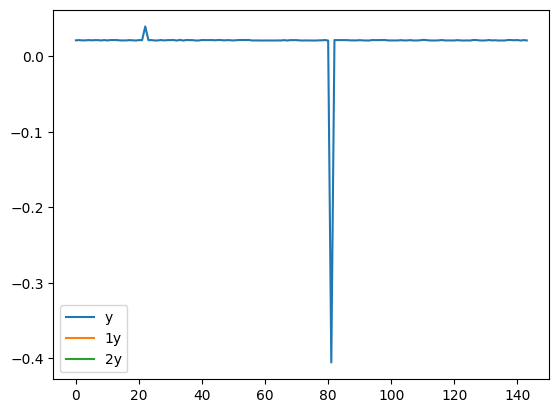

In [9]:
plt.plot(coordinate["0"]["y"], label="y")
plt.plot(coordinate["49"]["y"], label="1y")
plt.plot(coordinate["80"]["y"], label="2y")
plt.legend()

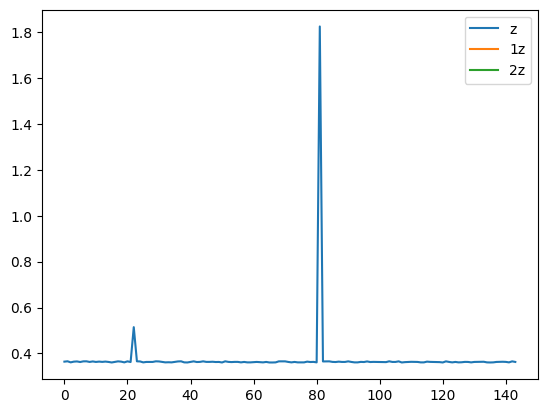

In [10]:
plt.plot(coordinate["0"]["z"], label="z")
plt.plot(coordinate["49"]["z"], label="1z")
plt.plot(coordinate["80"]["z"], label="2z")
plt.legend()

In [11]:
rmat = []
for i in range(len(coordinate["0"]["x"])):
    rotation_vectors = np.array([coordinate["0"]["rx"][i], coordinate["0"]["ry"][i], coordinate["0"]["rz"][i]])
    rotation_matrix = cv2.Rodrigues(rotation_vectors)[0]
    rmat.append(rotation_matrix)

In [12]:
df_0 = pd.DataFrame({"x":coordinate["0"]["x"], "y":coordinate["0"]["y"], "z":coordinate["0"]["z"]})
df_0 = pl.from_pandas(df_0)

tcoor_0 = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["0"]["x"])):
    val = _ar_lframe_rot.T @ (df_0[i].to_numpy().reshape(3,1) - _ar_lframe_org)

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_0["x"].append(x)
    tcoor_0["y"].append(y)
    tcoor_0["z"].append(z)

df_49 = pd.DataFrame({"x":coordinate["49"]["x"], "y":coordinate["49"]["y"], "z":coordinate["49"]["z"]})
df_49 = pl.from_pandas(df_49)

tcoor_49 = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["49"]["x"])):
    val = _ar_lframe_rot.T @ (df_49[i].to_numpy().reshape(3,1) - _ar_lframe_org)

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_49["x"].append(x)
    tcoor_49["y"].append(y)
    tcoor_49["z"].append(z)

df_80 = pd.DataFrame({"x":coordinate["80"]["x"], "y":coordinate["80"]["y"], "z":coordinate["80"]["z"]})
df_80 = pl.from_pandas(df_80)

tcoor_80 = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["80"]["x"])):
    val = _ar_lframe_rot.T @ (df_80[i].to_numpy().reshape(3,1) - _ar_lframe_org)

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_80["x"].append(x)
    tcoor_80["y"].append(y)
    tcoor_80["z"].append(z)

In [13]:
tcoor_df_0 = pd.DataFrame.from_dict(tcoor_0)
tcoor_df_49 = pd.DataFrame.from_dict(tcoor_49)
tcoor_df_80 = pd.DataFrame.from_dict(tcoor_80)

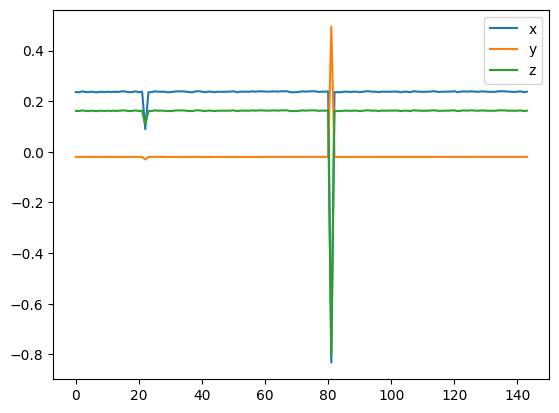

In [14]:
plt.plot(tcoor_0["x"], label="x")
plt.plot(tcoor_0["y"], label="y")
plt.plot(tcoor_0["z"], label="z")
plt.legend()

In [15]:
_mocap_pth = r"C:\Users\CMC\Documents\openposelibs\pose\DeepVision\recorded_data\cam_june_22_2023\sk40\sk40_30_4_static_mocap_3.csv"
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [16]:
_om = get_rb_marker_name(3)
_xm = get_rb_marker_name(4)
_zm = get_rb_marker_name(1)

In [17]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

zvec = [_mocap_df[_zm["x"]].iloc[0], _mocap_df[_zm["y"]].iloc[0], _mocap_df[_zm["z"]].iloc[0]]
zvec = np.array(zvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = zvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vzcap = v2 - (vxnorm.T @ v2) * vxnorm
vznorm = vzcap / np.linalg.norm(vzcap)

vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [18]:
@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [19]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 781/781 [00:01<00:00, 569.24it/s]


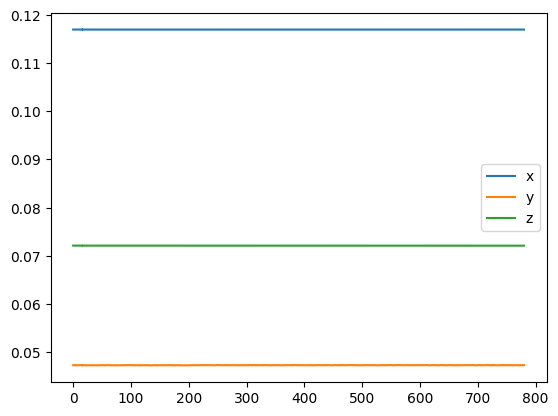

In [20]:
plt.plot(_mocap_df[_om["x"]], label="x")
plt.plot(_mocap_df[_om["y"]], label="y")
plt.plot(_mocap_df[_om["z"]], label="z")
plt.legend()

In [21]:
from ultralytics import YOLO

In [22]:
_model_name = "kaggle_aruco_multiclass.pt"
_model_pth = os.path.join(os.getcwd(), "..", "models", _model_name)
model = YOLO(_model_pth)

In [23]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [0, 49, 80]

data_ml = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0
val = None

ids = None
modelcorners = None
translation_vectors = None
rotation_vectors = None

for _frame in tqdm(_video_data):

    shape = _frame.shape
    result = model(_frame, verbose=False)[0]  
    modelcorners = []
    for _keys in result.keypoints.data:
        modelcorners.append(_keys[0:4].numpy())
    modelcorners = np.array(modelcorners)

    if len(result.boxes.cls.numpy()) != 0: # if there are any detections else None
        _idx = result.boxes.cls.numpy()
        ids = []
        for i in _idx:
            match i:
                case 0:
                    ids.append([0])
                case 1:
                    ids.append([49])
                case 2:
                    ids.append([80])
        ids = np.array(ids, dtype=np.int32)
    else:
        ids = None

    if len(modelcorners) != 0: # if there are any detections else skip

        try:
            rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(modelcorners, 0.04, _webcam_cam_mat, _webcam_dist)
        except:
            ids = None

    if ids is None:
        data_ml["frame_id"].append(counter)
        data_ml["marker_ids"].append(None)
        data_ml["corners"].append(None)
        data_ml["tvec"].append(None)
        data_ml["rvec"].append(None)

    if ids is not None:
        data_ml["frame_id"].append(counter)
        data_ml["marker_ids"].append(ids)
        data_ml["corners"].append(modelcorners)
        data_ml["tvec"].append(translation_vectors)
        data_ml["rvec"].append(rotation_vectors)

    counter+=1
    # break


_video_file.close()

142it [00:21,  6.61it/s]


In [24]:
coordinate_ml = {"0":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "49":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "80":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame
default_ids = [0, 49, 80]

for i in range(len(data_ml["frame_id"])):
    if data_ml["marker_ids"][i] is not None:

        if default_ids[0] not in data_ml["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data_ml["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data_ml["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        for j in range(len(data_ml["marker_ids"][i])):
            if data_ml["marker_ids"][i][j] in default_ids:
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["x"].append( data_ml["tvec"][i][j][0][0])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["y"].append( data_ml["tvec"][i][j][0][1])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["z"].append( data_ml["tvec"][i][j][0][2])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["rx"].append(data_ml["rvec"][i][j][0][0])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["ry"].append(data_ml["rvec"][i][j][0][1])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["rz"].append(data_ml["rvec"][i][j][0][2])
        for k in doesnt_exist:
            coordinate_ml[str(k)]["x"].append(np.nan)
            coordinate_ml[str(k)]["y"].append(np.nan)
            coordinate_ml[str(k)]["z"].append(np.nan)
            coordinate_ml[str(k)]["rx"].append(np.nan)
            coordinate_ml[str(k)]["ry"].append(np.nan)
            coordinate_ml[str(k)]["rz"].append(np.nan)
        doesnt_exist = []
    else:
        for k in default_ids:
            coordinate_ml[str(k)]["x"].append(np.nan)
            coordinate_ml[str(k)]["y"].append(np.nan)
            coordinate_ml[str(k)]["z"].append(np.nan)
            coordinate_ml[str(k)]["rx"].append(np.nan)
            coordinate_ml[str(k)]["ry"].append(np.nan)
            coordinate_ml[str(k)]["rz"].append(np.nan)

In [25]:
print(len(coordinate_ml["0"]["x"]), len(coordinate_ml["0"]["y"]), len(coordinate_ml["0"]["z"]))

142 142 142


In [26]:
df_0_ml = pd.DataFrame(coordinate_ml["0"])
df_49_ml = pd.DataFrame(coordinate_ml["49"])
df_80_ml = pd.DataFrame(coordinate_ml["80"])

In [27]:
translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

In [28]:
df_0_ml = pl.from_pandas(df_0_ml)

tcoor_0_ml = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate_ml["0"]["x"])):
    val = (_ar_lframe_rot.T @ (df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1) - _ar_lframe_org)) - translation_correction

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_0_ml["x"].append(x)
    tcoor_0_ml["y"].append(y)
    tcoor_0_ml["z"].append(z)


In [29]:
ts_df = pd.DataFrame({"ts":ts})
ts_df["ts"] = pd.to_datetime(ts_df["ts"])

ar_df = pl.DataFrame({"time":ts,"x":tcoor_0_ml["x"], "y":tcoor_0_ml["y"], "z":tcoor_0_ml["z"]})

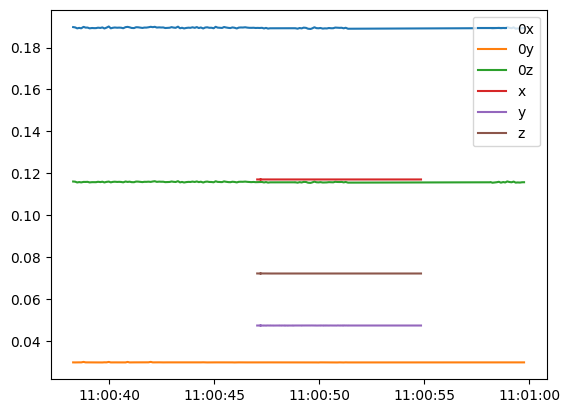

In [30]:
plt.plot(ts_df["ts"],np.array(tcoor_0_ml["x"]), label="0x")
plt.plot(ts_df["ts"],np.array(tcoor_0_ml["y"]), label="0y")
plt.plot(ts_df["ts"],np.array(tcoor_0_ml["z"]), label="0z")

plt.plot(_mocap_df["time"],_mocap_df[_om["x"]], label="x")
plt.plot(_mocap_df["time"],_mocap_df[_om["y"]], label="y")
plt.plot(_mocap_df["time"],_mocap_df[_om["z"]], label="z")

plt.legend()

In [31]:
diff = -np.array([_mocap_df[_om["x"]][0]  - tcoor_0_ml["x"][0], _mocap_df[_om["y"]][0]- tcoor_0_ml["y"][0], _mocap_df[_om["z"]][0]- tcoor_0_ml["z"][0]])
print(diff)
print(diff.reshape(3,1))

[   0.072756   -0.017603    0.043909]
[[   0.072756]
 [  -0.017603]
 [   0.043909]]


In [32]:
print("length of the vector",np.linalg.norm(diff.reshape(3,1)))

length of the vector 0.08678370976756371


Bringing to skateboard frame

In [33]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

zvec = [_mocap_df[_zm["x"]].iloc[0], _mocap_df[_zm["y"]].iloc[0], _mocap_df[_zm["z"]].iloc[0]]
zvec = np.array(zvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = zvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vzcap = v2 - (vxnorm.T @ v2) * vxnorm
vznorm = vzcap / np.linalg.norm(vzcap)

vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [34]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 781/781 [00:00<00:00, 1914.22it/s]


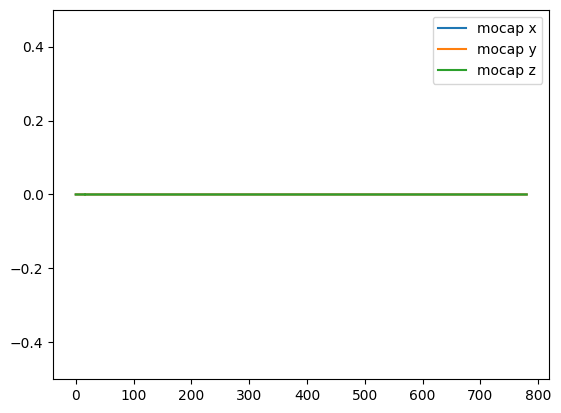

In [35]:
plt.plot(_mc_df["x"], label="mocap x")
plt.plot(_mc_df["y"], label="mocap y")
plt.plot(_mc_df["z"], label="mocap z")
plt.ylim(-0.5, 0.5)
plt.legend()

In [45]:
transform_ml = {"x":[], "y":[], "z":[]}
for i in range(len(ar_df)):
    # val = (rotMat.T @ (ar_df[["x", "y", "z"]][i].to_numpy().reshape(3,1) - ar_df[["x", "y", "z"]][0].to_numpy().reshape(3,1)))
    val = (rotMat.T @ (ar_df[["x", "y", "z"]][i].to_numpy().reshape(3,1) - diff.reshape(3,1)))

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    transform_ml["x"].append(x)
    transform_ml["y"].append(y)
    transform_ml["z"].append(z)


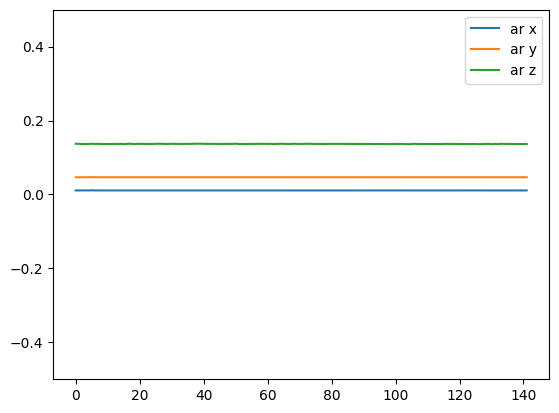

In [46]:
plt.plot(transform_ml["x"], label="ar x")
plt.plot(transform_ml["y"], label="ar y")
plt.plot(transform_ml["z"], label="ar z")
plt.ylim(-0.5, 0.5)
plt.legend()

In [47]:
print(transform_ml["x"][0], transform_ml["y"][0], transform_ml["z"][0])

0.010934502628560015 0.04660191664276027 0.1372268106875884
